<h1 align='center'>  Bangalore Air Quality Prediction </h1>
<h3 align='center'>  To predict the Air Quality of Bangalore City from 2013-2018 </h3>

## 0. Import relevant Dependencies

Incase you are getting any error saying the package is not installed while running the below cell, then you can use two methods:
- pip install ________.
- google 'How to install ________'.

In [1]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Display all the columns/rows of the DataFrame.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Loading the required Data

In [2]:
df = pd.read_csv('Data/Real-Data/Real_Combine.csv')
df.head()

,T,TM,Tm,H,VV,V,VM,PM 2.5
0,23.4,30.3,19.0,59.0,6.3,4.3,5.4,284.795833
1,22.4,30.3,16.9,57.0,6.9,3.3,7.6,219.720833
2,24.0,31.8,16.9,51.0,6.9,2.8,5.4,182.187500
3,22.8,30.2,17.6,55.0,7.7,3.7,7.6,154.037500
4,23.1,30.6,17.4,46.0,6.9,3.3,5.4,223.208333


In [3]:
print('Dimensionality of the obtained Data is: ', df.shape)

Dimensionality of the obtained Data is:  (737, 8)


## 2. Feature Engineering

In [4]:
# Understanding more about the missing value columns

def missing_values_table(df):
    # number of missing values
    mis_val = df.isnull().sum()

    # % of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # make table # axis '0' concat along index, '1' column
    mis_val_table = pd.concat([mis_val,mis_val_percent], axis= 1) 

    # rename columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})

    # sort by column
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!= 0].sort_values(
        '% of Total Values', ascending= False).round(1) #Review
    print("Your selected dataset has " + str(df.shape[1]) + " columns and " + str(len(df)) + " observations.\n"
         "\n There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    
    # return the dataframe with missing info
    return mis_val_table_ren_columns

missing_values_table(df)

Your selected dataset has 8 columns and 737 observations.

 There are 1 columns that have missing values.


,Missing Values,% of Total Values
PM 2.5,1,0.1


In [5]:
## Dropping the Null Values
df = df.dropna()

In [6]:
## Splitting our Data to Dependent and Independent Features
X = df.iloc[:,:-1] ### Independent Features
y = df.iloc[:,-1] ### Dependent Features

<AxesSubplot:xlabel='PM 2.5', ylabel='Density'>

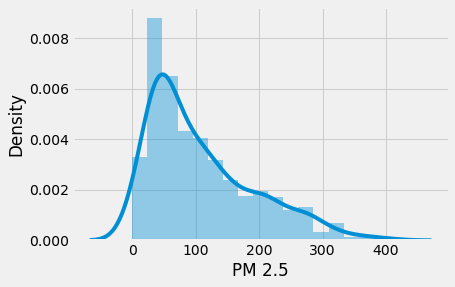

In [7]:
## Understanding the Distribution
sns.distplot(y)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## 3 Random Forest Regressor Model

In [9]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()    ##Initializing Random Forest by just the criterion.

In [10]:
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [11]:
print(f'Coefficient of Determination R2 <-- on train set is: {regressor.score(X_train, y_train)}')
print()
print(f'Coefficient of Determination R2 <-- on test set is: {regressor.score(X_test, y_test)}')

Coefficient of Determination R2 <-- on train set is: 0.9194292952445554

Coefficient of Determination R2 <-- on test set is: 0.3379723576459326


- This is purely a situation of ***Overfitting***

In [12]:
## Trying with CrossValidation.
from sklearn.model_selection import cross_val_score
score = cross_val_score(regressor, X, y, cv = 5)        ## Because cross_val_score inturn divides the datasets into train and test
score.mean()

0.2582792693577461

### Model Evaluation

<AxesSubplot:xlabel='PM 2.5', ylabel='Density'>

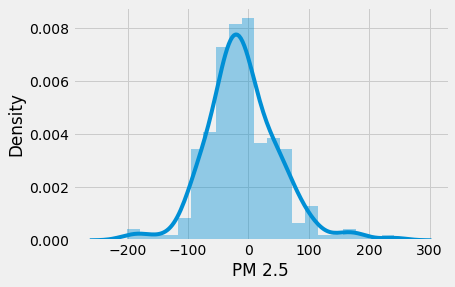

In [13]:
## Predict
prediction = regressor.predict(X_test)
sns.distplot(y_test-prediction)

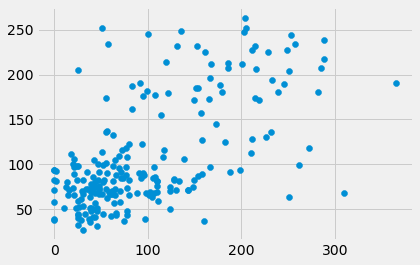

In [14]:
plt.scatter(y_test, prediction)

### 3.1 HyperParameter Tuning - Random Forest Regressor

In [15]:
## Randomized Search CV - Faster than GridSearchCV

# The number of trees in the forest.
n_estimators = [int(x) for x in np.linspace(start= 100, stop= 1200, num= 12)]
# The number of features to consider when looking for the best split
max_features = ['auto', 'sqrt']
# The maximum depth/levels of the tree.
max_depth = [int(x) for x in np.linspace(5, 30, num= 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

In [16]:
## Hyper Parameter Optimization

## Key Dictionary
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [17]:
## Hyper-Parameter Optimization Using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

In [20]:
rf_search = RandomizedSearchCV(estimator= rf, param_distributions= random_grid, scoring= 'neg_mean_squared_error', n_iter = 100, cv = 5, verbose=2, random_state= 42, n_jobs = 1)

In [21]:
rf_search.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   6.1s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   5.9s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5 
[CV]  n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   6.2s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5 
[CV]  n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   5.7s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5 
[CV]  n_estimators=400, min_samples_split=100, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   5.9s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=20 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=20, total=   7.7s
[CV] n_estimators=200, min_samples_spl

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 36.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [22]:
rf_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 5}

In [23]:
rf_search.best_score_

-3761.4234731355295

### Model Evaluation - HyperParameter Tuning

> #### This will never lead to overfitting as we had done Hyperparameter Tuning. This will give us a generalized model.

<AxesSubplot:xlabel='PM 2.5', ylabel='Density'>

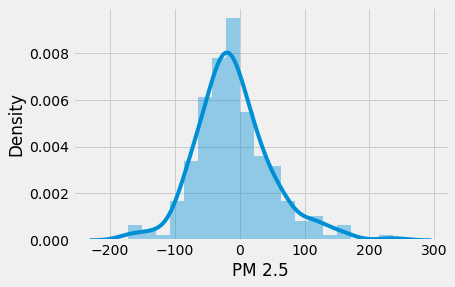

In [24]:
## Predict
prediction = rf_search.predict(X_test)
sns.distplot(y_test-prediction)

## Regression Evaluation Metrics

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error (MAE)** is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error (MSE)** is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error (RMSE)** is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

### Comparing these metrics:

- MAE is the easiest to understand, because it's the average error.
- MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are loss functions, because we want to minimize them.



In [26]:
from sklearn import metrics
print('MAE: ', metrics.mean_absolute_error(y_test, prediction))
print('MSE: ', metrics.mean_squared_error(y_test, prediction))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE:  45.14150956570478
MSE:  3509.154549388043
RMSE:  59.2381173687014


> #### Here we can see that Random Forest performs better than all our other three models.

In [27]:
import pickle

## Open a file, where we want to store the data.
file = open('random_forest_model.pkl', 'wb')

## Dump all the information to this file.
pickle.dump(rf_search, file)